#### Imports

In [1]:
import math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import torch.nn.functional as F
from PIL import Image
import seaborn as sns
import cv2
from kornia.utils import one_hot
from torchvision import transforms

from kedro.extras.datasets.pickle import PickleDataSet
from kedro.config import ConfigLoader

In [2]:
import os, sys
sys.path.append(os.path.abspath('..'))

from src.tagseg.data.acdc_dataset import AcdcDataSet
from src.tagseg.pipelines.data_splitting.nodes import split_data

#### Fetch preprocessed data

In [3]:
conf_paths = ["../conf/base", "../conf/local"]
conf_loader = ConfigLoader(conf_paths)
conf_catalog = conf_loader.get("catalog*", "catalog*/**")

In [4]:
dataset = PickleDataSet(filepath='../' + conf_catalog['acdc_data_tagged']['filepath']).load()

#### Load images and play around

In [5]:
image, label = dataset[50]

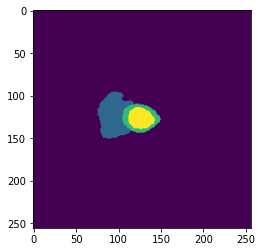

In [6]:
plt.imshow(label)

In [7]:
nlabel = one_hot(label.long().unsqueeze(0), 4)
inp = nlabel.squeeze()

In [22]:
def directional_field(x: np.ndarray) -> np.ndarray:

    result = np.zeros((2, *x.shape), dtype=np.float32)

    _, ind = ndimage.distance_transform_edt(x.astype(np.uint8), return_indices=True)
    diff = np.indices(x.shape) - ind

    # Assign (x, y) distance
    result[:, x > 0] = diff[:, x > 0]

    # Cartesian to polar coordinates
    result = np.stack([
        (result ** 2).sum(axis=0) ** .5,  # sqrt(x^2 + y^2)
        np.arctan(result[1] / (result[0] + 1e-8))  # arctan(y/x)
    ])

    return result

In [23]:
df = np.array(
    list(map(directional_field, inp[1:].numpy()))
).sum(axis=0)

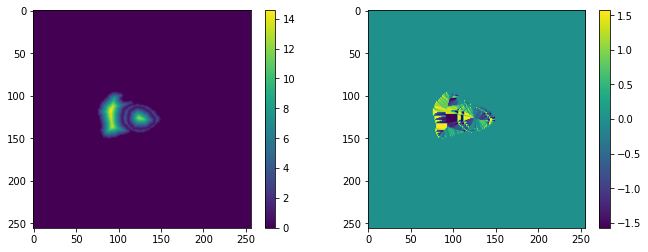

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

pos = []

for i in range(2):
    pos.append(ax[i].imshow(df[i]))

fig.colorbar(pos[0], ax=ax[0])
fig.colorbar(pos[1], ax=ax[1])